In [53]:
import argparse
import torch
from utils import get_model, LoadEncoder
from models.engine import DDIMSampler, DDIMSamplerEncoder
from torchvision.utils import save_image, make_grid
from collections import OrderedDict
from PIL import Image
import numpy as np

In [56]:
class Args(argparse.Namespace):
    arch = "unet"
    img_size=64
    num_timestep = 1000
    beta = (0.0001, 0.02)
    num_condition = [4, 2]
    emb_size = 128
    channel_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    use_spatial_transformer = True
    num_heads = 4
    num_sample_missing = 100
    num_sample = 10
    w = 1.8
    projection_dim=512
    only_table = False
    concat = False
    only_encoder = False
    num_head_channels = -1
    encoder_path = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

In [57]:
model = get_model(args)

ckpt = torch.load("checkpoints/CelebA/GrayFemaleAdaGN/model_100.pth")["model"]
new_dict = OrderedDict()
    
for k, v in ckpt.items():
    if k.startswith("module"):
        new_dict[k[7:]] = v
    else:
        new_dict[k] = v
try:
    model.load_state_dict(new_dict)
    print("All keys successfully match")
except:
    print("some keys are missing!")

for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to(device)

sampler = DDIMSampler(
    model=model,
    beta =args.beta,
    T=args.num_timestep,
    w=args.w,
).to(device)

if args.encoder_path != None:
    encoder = LoadEncoder(args).to(device)
    sampler = DDIMSamplerEncoder(
            model = model,
            encoder = encoder,
            beta = args.beta,
            T = args.num_timestep,
            w = args.w,
            only_encoder = args.only_encoder
    ).to(device)

All keys successfully match


In [58]:
from config import Zappo50K, toy_dataset, CelebA

CFG = CelebA()
# CFG = Zappo50K()
# missing = "Heel Slipper"
# targets = ["Flat Boot", "Flat Shoe", "Flat Slipper", "Flat Sandal", "Heel Boot", "Heel Shoe", "Heel Sandal"]
missing = "Gray_Hair Female"
targets = ["Brown_Hair Male", "Black_Hair Male", "Gray_Hair Male", "Blond_Hair Male", "Brown_Hair Female", "Black_Hair Female", "Blond_Hair Female"]

atr, obj = CFG.ATR2IDX[missing.split(" ")[0]], CFG.OBJ2IDX[missing.split(" ")[-1]]
atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(args.num_sample_missing)
obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(args.num_sample_missing)
x_i = torch.randn(args.num_sample_missing, 3, 64, 64).to(device)
x0 = sampler(x_i, atr, obj, steps=100)
x0 = x0 * 0.5 + 0.5
save_image(x0, "SampledImg/DualCond/GrayFemaleAdaGN.png", nrow=10, noramlized=True)

images = []
for target in targets:
    atr, obj = CFG.ATR2IDX[target.split(" ")[0]], CFG.OBJ2IDX[target.split(" ")[-1]]
    atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(args.num_sample)
    obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(args.num_sample)

    x_i = torch.randn(args.num_sample, 3, 64, 64).to(device)
    x0 = sampler(x_i, atr, obj, steps=100)
    x0 = x0 * 0.5 + 0.5
    images.append(x0)
images = torch.concatenate(images, dim=0)
save_image(images, "SampledImg/DualCond/SeenAdaGN.png", nrow=args.num_sample, normalized=True)

100%|██████████| 100/100 [00:06<00:00, 16.58it/s, step=1, sample=1]


In [12]:
def _image_grid(imgs, rows, cols):
        """
        input -
        1. imgs - np array dims num_images x **(image_dims)
        2. rows, cols - number of rows and columns in the image grid
        output - 
        1. saved image grid on the disk at the end when all the images are pasted after multiple iterations
        """
        n,c,w,h = imgs.shape

        grid = Image.new('RGB', size=(cols*w, rows*h))
        
        if isinstance(imgs, torch.Tensor):
            imgs = imgs.cpu().numpy()

        grid_w, grid_h = grid.size
        for idx in range(n):
            img = imgs[idx,:].squeeze()
            img = Image.fromarray(img)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            grid.paste(img, box=(idx*w, 0))
        return grid

In [24]:
imgs = images.cpu().numpy()
img = imgs[0, :].squeeze()
# img = Image.fromarray((img * 255).astype(np.uint8))

3

In [108]:
from PIL import Image
import os
from glob import glob
import random
import matplotlib.pyplot as plt
import cv2


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

data_root = "/root/notebooks/nfs/work/dataset/toy_dataset_1000"
imgs = []
for tar in sorted(os.listdir(data_root)):
    im = cv2.imread(os.path.join(data_root, tar, "00001.jpg"))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    tmp = tar[0].upper() + tar[1:]
    imgs.append((tmp,  im))

# grid = image_grid(imgs, 6, 6)
# grid.save("shape.png")

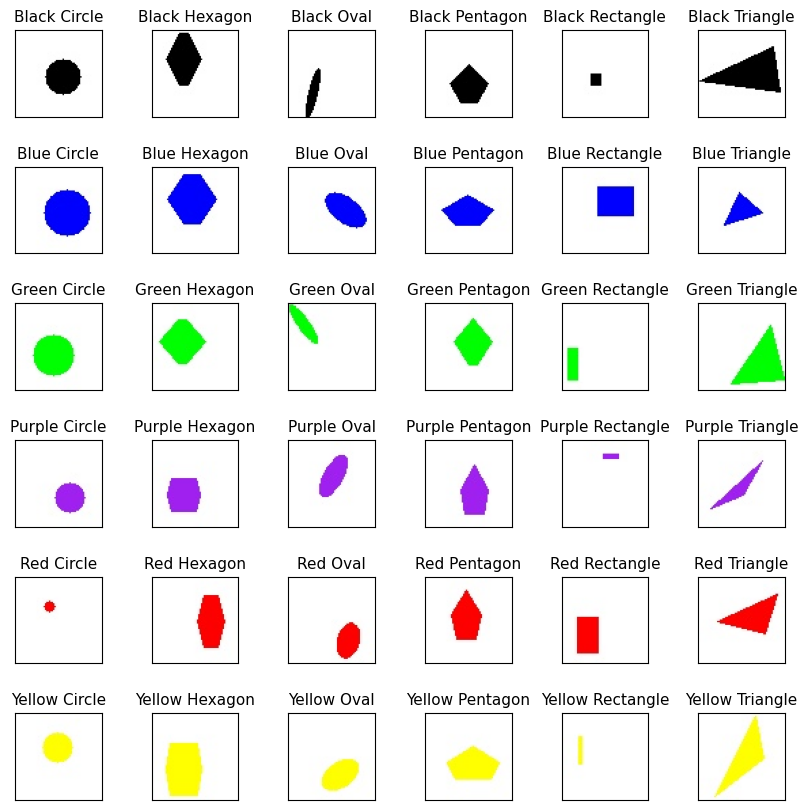

In [115]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 6), axes_pad=0.5)

for ax, img in zip(grid, imgs):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{img[0]}", fontsize=11)
    ax.imshow(img[1])
plt.savefig("shapecolor.png", bbox_inches='tight')

('black Circle',
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [2